In [75]:
import os
import numpy as np
import random
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torchvision import transforms, models
from torchvision.transforms import functional as F

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

In [68]:
def compute_mean_std(loader):
    # Variables to accumulate the sum of all pixels in each channel
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    
    for images, _ in loader:
        channels_sum += torch.mean(images, dim=[0,2,3])
        channels_squared_sum += torch.mean(images**2, dim=[0,2,3])
        num_batches += 1
    # Compute mean and std dev
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

# Calculate mean and standard deviation
#mean, std = compute_mean_std(dataloader_train)

In [85]:
class CustomTransform:
    def __call__(self, x):
        # x is a PyTorch tensor of the image

        # Ensure image is in the expected format [C, H, W]
        if x.ndim == 2:  # If the image is grayscale, unsqueeze to add a channel dimension
            x = x.unsqueeze(0)

        x = F.resize(x, [224, 224])
        
        # Step 1: Rotate the image by 180 degrees
        rotated_image = F.rotate(x, 180)

        # Step 2: Subtract the rotated image from the original
        subtracted_image = torch.sub(x, rotated_image)

        # Step 3: Rescale the subtracted result to the 0-255 range
        subtracted_image = subtracted_image - subtracted_image.min()
        subtracted_image = subtracted_image / subtracted_image.max()

        # Step 4: Make central reflection
        flipped_image = F.hflip(x)
        flipped_image = F.rotate(flipped_image, 180)

        # Step 5: Rescale the subtracted result to the 0-255 range
        flipped_image = torch.sub(x, flipped_image)
        flipped_image = flipped_image - flipped_image.min()
        flipped_image = flipped_image / flipped_image.max()

        # Ensure the subtracted_image has the same dimensions as the input, for grayscale images
        if subtracted_image.ndim == 2:
            subtracted_image = subtracted_image.unsqueeze(0)

        # Step 4: Append the rescaled result as a new channel to the input image
        result_image = torch.cat((x, subtracted_image, flipped_image), dim=0)  # Assuming x is [C, H, W]
    
        mean = [0.0617, 0.5000, 0.5000]
        std = [0.1168, 0.0678, 0.0655]
        result_image = F.normalize(result_image, mean=mean, std=std)
        
        return result_image


class LensDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images (e.g., 'A/B/C').
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.filepaths = []
        self.labels = []

        label_numeric = {
            "no": 0,
            "sphere": 1,
            "vort": 2
        }

        for label_dir in os.listdir(root_dir):
            label_path = os.path.join(root_dir, label_dir)
            for filename in os.listdir(label_path):
                self.filepaths.append(os.path.join(label_path, filename))
                self.labels.append(label_numeric[label_dir])

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.filepaths[idx]
        image = np.load(img_path)
        image = torch.from_numpy(image).float()
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [77]:
def load_dataset_cifer():
    dataset_path = './data_cifar'
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])
    trainset = torchvision.datasets.CIFAR10(root=dataset_path, train=True,
                                            download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                              shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root=dataset_path, train=False,
                                           download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                             shuffle=False, num_workers=2)

    # Class names for CIFAR-10 dataset
    classes = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')

    return trainset, trainloader, testset, testloader, classes

In [86]:
def load_dataset():
    # Usage
    drive_dir = "./"
    train_dir = f'{drive_dir}/dataset/train'  # Change this path to your dataset's root directory

    dataset_train = LensDataset(train_dir, transform=CustomTransform())
    #dataset_train = LensDataset(train_dir, transform=transform)
    sampler_train = RandomSampler(dataset_train)

    dataloader_train = DataLoader(dataset_train, batch_size=32, sampler=sampler_train)

    val_dir = f'{drive_dir}/dataset/val'  # Change this path to your dataset's root directory
    dataset_val = LensDataset(val_dir, transform=CustomTransform())
    #dataset_val = LensDataset(val_dir, transform=transform)
    sampler_val = RandomSampler(dataset_val)
    dataloader_val = DataLoader(dataset_val, batch_size=32, sampler=sampler_val)

    # Class names for CIFAR-10 dataset
    classes = ("no", "sphere", "vort")

    return dataset_train, dataloader_train, dataset_val, dataloader_val, classes

In [90]:
def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0
    # Switch to train mode
    model.train()
    for inputs, labels in tqdm(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item() * inputs.size(0)

        # Compute training accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # Compute average training loss and accuracy
    train_loss = train_loss / len(trainloader.dataset)
    train_accuracy = 100.0 * train_correct / train_total

    return model, train_loss, train_accuracy

def test(model, testloader, criterion, device):
    test_loss = 0.0
    test_total = 0
    test_correct = 0

    # Switch to evaluation mode
    model.eval()

    with torch.no_grad():
        for inputs, labels in tqdm(testloader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update test loss
            test_loss += loss.item() * inputs.size(0)

            # Compute test accuracy
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    # Compute average test loss and accuracy
    test_loss = test_loss / len(testloader.dataset)
    test_accuracy = 100.0 * test_correct / test_total

    return test_loss, test_accuracy

def train_epochs(model, trainloader, testloader, criterion, optimizer, device, num_epochs, save_interval=5):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        model, train_loss, train_accuracy = train(model, trainloader, criterion, optimizer, device)
        test_loss, test_accuracy = test(model, testloader, criterion, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f'Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.2f}%')
        print(f'Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.2f}%')
        print()

        if (epoch + 1) % save_interval == 0 and False:
          # Save the model and variables
          torch.save(model.state_dict(), f'resnet50_cifar10_{epoch+1}.pth')
          checkpoint = {
              'epoch': epoch + 1,
              'train_losses': train_losses,
              'train_accuracies': train_accuracies,
              'test_losses': test_losses,
              'test_accuracies': test_accuracies,
              'classes': classes
          }
          torch.save(checkpoint, f'resnet50_cifar10_variables_{epoch+1}.pth')

    return model, train_losses, train_accuracies, test_losses, test_accuracies


In [88]:
def plot_loss(train_losses, test_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(test_losses)), test_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss_plot.png')
    plt.show()

def plot_accuracy(train_accuracies, test_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)), train_accuracies, label='Training Accuracy')
    plt.plot(range(len(test_accuracies)), test_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('accuracy_plot.png')
    plt.show()
def plot_image(dataset, model, classes):
    idx = random.randint(0, len(dataset))
    label = dataset[idx][1]
    img = dataset[idx][0].unsqueeze(0).to(device)  # Move the input image tensor to the GPU
    model.eval()
    #model.to(device)  # Move the model to the GPU
    output = model(img)
    _, predicted = torch.max(output.data, 1)
    # Convert the image and show it
    img = img.squeeze().permute(1, 2, 0).cpu()  # Move the image tensor back to the CPU and adjust dimensions
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {classes[predicted]}, True: {classes[label]}')
    plt.savefig('predicted_image.png')
    plt.show()
    print("Predicted label: ", classes[predicted[0].item()])
    print("Actual label: ", classes[label])

In [97]:
if True:
    train_model = True
    # Set random seed for reproducibility
    random_seed = 42
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)

    # Number of classes
    num_classes = 3

    # Import ResNet50 model pretrained on ImageNet
    model = models.resnet50(pretrained=True)
    #print("Network before modifying conv1:")
    #print(model)

    #Modify conv1 to suit CIFAR-10
    #model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

    # Modify the final fully connected layer according to the number of classes
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    #print("Network after modifying conv1:")
    #print(model)

    # Move the model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

    # Load the dataset
    trainset, trainloader, testset, testloader, classes = load_dataset()

    if train_model:
      # Train the model for 20 epochs, saving every 5 epochs
      num_epochs = 20
      save_interval = 5
      model, train_losses, train_accuracies, test_losses, test_accuracies = train_epochs(
          model, trainloader, testloader, criterion, optimizer, device,
          num_epochs, save_interval)

      # Save the final trained model
      torch.save(model.state_dict(), f'resnet50_cifar10_final_model_epochs_{num_epochs}.pth')

      # Plot and save the loss and accuracy plots
      plot_loss(train_losses, test_losses)
      plot_accuracy(train_accuracies, test_accuracies)
    else:
      # Load the pre-trained model
      model.load_state_dict(torch.load('resnet50_cifar10_final_model_epochs_50.pth'))
      # Load the variables
      checkpoint = torch.load("resnet50_cifar10_variables.pth")
      epoch = checkpoint['epoch']
      train_losses = checkpoint['train_losses']
      train_accuracies = checkpoint['train_accuracies']
      test_losses = checkpoint['test_losses']
      test_accuracies = checkpoint['test_accuracies']
      classes = checkpoint['classes']
      model.to(device)
      model.eval()

    # Plot and save an example image
    plot_image(testset, model, classes)

Epoch 1/10


  0%|          | 4/938 [00:22<1:26:25,  5.55s/it]

KeyboardInterrupt



In [92]:
torch.save(model.state_dict(), f'resnet50_lense_model_epochs_4.pth')

In [95]:
for inputs, labels in trainloader:
    print(inputs)
    print(labels)
    break

tensor([1, 2, 1, 0, 0, 2, 0, 0, 0, 1, 2, 2, 2, 1, 1, 2, 1, 0, 1, 1, 2, 1, 0, 0,
        1, 0, 0, 0, 2, 1, 2, 1])


In [81]:
for inputs, labels in trainloader:
    inputs, labels = inputs.to(device), labels.to(device)
    break

In [83]:
inputs.shape

torch.Size([32, 3, 32, 32])

In [ ]:
# Usage
drive_dir = "./"
train_dir = f'{drive_dir}/dataset/train'  # Change this path to your dataset's root directory

dataset_train = LensDataset(train_dir, transform=CustomTransform())
#dataset_train = LensDataset(train_dir, transform=transform)
sampler_train = RandomSampler(dataset_train)

dataloader_train = DataLoader(dataset_train, batch_size=100, sampler=sampler_train)

val_dir = f'{drive_dir}/dataset/val'  # Change this path to your dataset's root directory
dataset_val = LensDataset(val_dir, transform=CustomTransform())
#dataset_val = LensDataset(val_dir, transform=transform)
sampler_val = RandomSampler(dataset_val)
dataloader_val = DataLoader(dataset_val, batch_size=100, sampler=sampler_val)


criterion = nn.CrossEntropyLoss()
#criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
resnet50 = models.resnet50()
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 10)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet50.to(device)

In [66]:
num_epochs = 10  # Number of training epochs

for epoch in range(num_epochs):
    resnet50.train()  # Set model to training mode
    running_loss = 0.0
    current_count = 0
    for inputs, labels in tqdm(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = resnet50(inputs)  # Forward pass
        _, predicted = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize

        running_loss += loss.item()
        current_count += 1
        if current_count%1000 == 0:
            print(f"Epoch {epoch+1}, Loss: {running_loss/current_count}")
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(dataloader_train)}")
    scheduler.step()

 64%|██████▍   | 1003/1563 [01:13<00:33, 16.66it/s]

Epoch 1, Loss: 2.553768427371979


100%|██████████| 1563/1563 [01:48<00:00, 14.35it/s]


Epoch 1, Loss: 13.311263078053793


 64%|██████▍   | 1002/1563 [01:17<00:46, 12.10it/s]

Epoch 2, Loss: 2.54626572060585


100%|██████████| 1563/1563 [01:58<00:00, 13.18it/s]


Epoch 2, Loss: 13.265535162289938


 15%|█▍        | 227/1563 [00:16<01:39, 13.37it/s]


KeyboardInterrupt: 

In [47]:
resnet50.eval()  # Set model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in dataloader_val:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet50(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

KeyboardInterrupt: 

In [48]:
correct

1006

In [49]:
total

3000

In [50]:
labels, outputs, predicted

(tensor([1, 1, 2, 2, 2, 1, 0, 0, 1, 2, 0, 2, 0, 2, 2, 0, 0, 1, 0, 2, 2, 1, 2, 0,
         2, 1, 2, 2, 1, 2, 0, 0, 0, 1, 1, 2, 1, 2, 0, 0, 0, 0, 2, 2, 0, 1, 0, 2,
         1, 2], device='cuda:0'),
 tensor([[-0.8725,  0.4305, -0.2512],
         [-0.4847,  0.3888, -0.6773],
         [-0.5531,  0.2238, -0.6717],
         [-1.0911,  0.4776, -0.2516],
         [-0.6520,  0.0903, -0.4618],
         [-0.4457,  0.0325, -0.4320],
         [-0.3752,  0.2121, -0.6279],
         [-0.9696,  0.3987, -0.3858],
         [-0.6115,  0.3779, -0.5850],
         [-0.4282,  0.1544, -0.5444],
         [-0.9457,  0.6241, -0.4125],
         [-0.7457,  0.3638, -0.5577],
         [-0.5630,  0.3975, -0.3497],
         [-0.4928,  0.2843, -0.5348],
         [-1.3015,  0.4583, -0.3357],
         [-0.5947,  0.3834, -0.6168],
         [-1.6134,  0.6813, -0.2079],
         [-0.3874,  0.0752, -0.5781],
         [-0.9775,  0.4537, -0.4875],
         [-0.8803,  0.2049, -0.2569],
         [-0.5344, -0.0067, -0.3801],
      

In [51]:
inputs[2][0]

tensor([[-0.3743, -0.4002, -0.4274,  ..., -0.4086, -0.4458, -0.4872],
        [-0.3794, -0.4053, -0.4272,  ..., -0.4489, -0.4539, -0.4561],
        [-0.3774, -0.4078, -0.4296,  ..., -0.4793, -0.4618, -0.4345],
        ...,
        [-0.4247, -0.4270, -0.4306,  ..., -0.4488, -0.4439, -0.4399],
        [-0.3949, -0.4155, -0.4376,  ..., -0.4477, -0.4385, -0.4256],
        [-0.3845, -0.4156, -0.4479,  ..., -0.4492, -0.4411, -0.4256]],
       device='cuda:0')

In [52]:
import matplotlib.pyplot as plt

def plotChannels(image):
    plt.figure(figsize=(15, 5))  # Adjust the size as needed

    for i in range(3):
        # Display the first image
        plt.subplot(1, 3, i+1)  # 1 row, 3 columns, 1st subplot
        plt.imshow(image[0][i], cmap='gray')
        plt.title(f'Channel {i}')
        plt.axis('off')  # Hide the axes

    # Adjust layout to not overlap plots
    plt.tight_layout()

    # Show the plot
    plt.show()

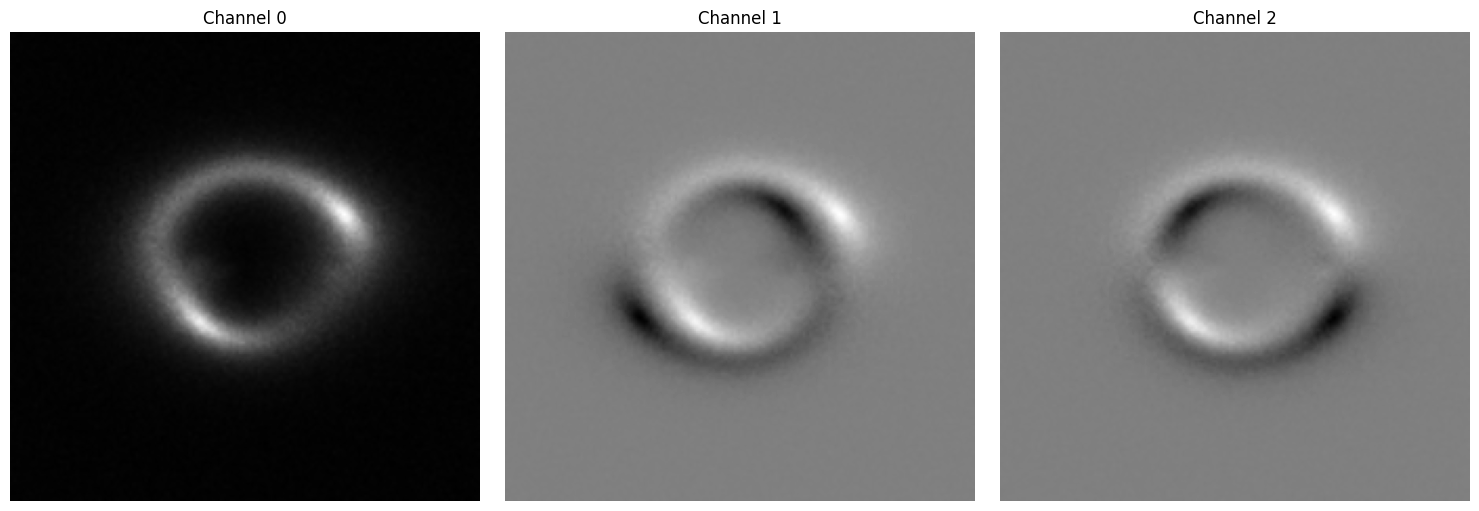

In [96]:
plotChannels(inputs.detach().cpu())

In [22]:
labels

tensor([2, 2, 2, 0, 2, 0, 0, 1, 2, 1], device='cuda:0')